In [2]:
import scipy.io
import mne
import pickle

import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy import io
from scipy import stats

from scipy.signal import spectrogram
from scipy.stats import entropy, skew
from scipy.linalg import toeplitz, cholesky


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
# 1. 导入MAT文件
mat_data = scipy.io.loadmat('data/indy_20161005_06.mat')

In [4]:
print(type(mat_data))
for k,v in mat_data.items():
    print(f"{k}，{type(v)}")

<class 'dict'>
__header__，<class 'bytes'>
__version__，<class 'str'>
__globals__，<class 'list'>
chan_names，<class 'numpy.ndarray'>
cursor_pos，<class 'numpy.ndarray'>
finger_pos，<class 'numpy.ndarray'>
spikes，<class 'numpy.ndarray'>
t，<class 'numpy.ndarray'>
target_pos，<class 'numpy.ndarray'>
wf，<class 'numpy.ndarray'>


In [5]:
# 提取数据
chan_names = mat_data['chan_names'].flatten()  #通道数96
chan_names=np.array([k[0] for k in chan_names])
cursor_pos = mat_data['cursor_pos']  #光标的位置
finger_pos = mat_data['finger_pos']  #指尖
spikes = mat_data['spikes']          #神经数据：unsorted/sorted
t = mat_data['t'].flatten()          #采样时间戳
target_pos = mat_data['target_pos']  #目标出现的xy
wf = mat_data['wf']                  #每个通道神经元发放波形

In [6]:
print(chan_names.shape)
print(cursor_pos.shape)
print(finger_pos.shape)
print(spikes.shape)
print(t.shape)
print(target_pos.shape)
print(wf.shape)

(96,)
(93501, 2)
(93501, 3)
(96, 5)
(93501,)
(93501, 2)
(96, 5)


<class 'numpy.ndarray'> (64,)


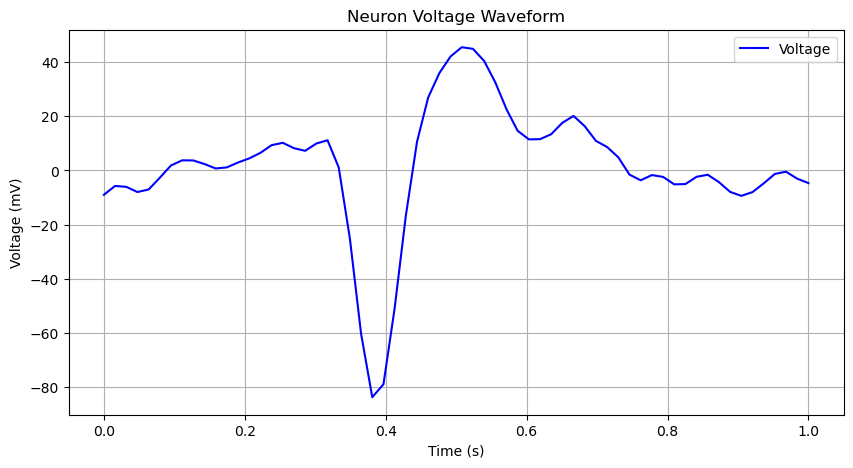

In [8]:
time = np.linspace(0, 1, 64)  # 生成从0到1秒的时间轴
voltage = wf[0,1][0,:]  # 

print(type(voltage),voltage.shape)
# # 创建电压波形图
plt.figure(figsize=(10, 5))
plt.plot(time, voltage, color='b', label='Voltage')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Neuron Voltage Waveform')
plt.legend()
plt.grid()
plt.show()


(3894, 64)


D:\software\anaconda3_2021_05_x86_64\anaconda\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(3894, 2) (4, 2) [[-26.974567  76.699554]
 [ 42.2652    28.75058 ]
 [-38.95142  -23.956244]
 [107.66917  -32.1009  ]]


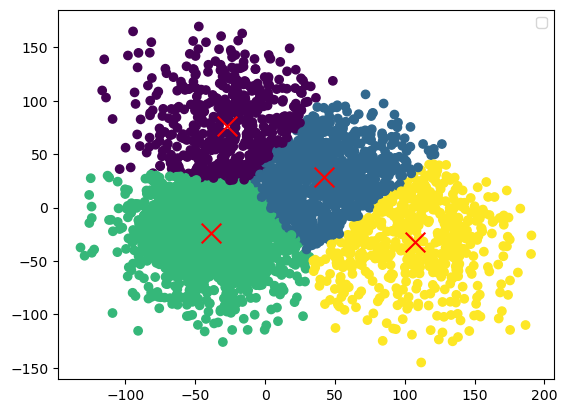

In [20]:
concatenated_data = np.concatenate((wf[1,1], wf[1,2],wf[1,3],wf[1,4]), axis=0)

pca = PCA(n_components=2)  # 将数据降到2维
reduced_data = pca.fit_transform(concatenated_data)

# 定义K-means模型
kmeans = KMeans(n_clusters=4) # 将数据分为3个簇

# 进行聚类
kmeans.fit(reduced_data)

# 获取聚类结果
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print(reduced_data.shape,centroids.shape,centroids)

# 可视化聚类结果
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200)
plt.legend()
plt.show()


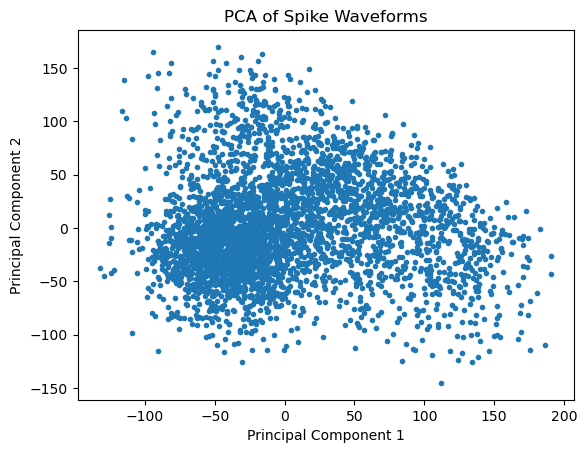

In [46]:
# 使用PCA进行降维
pca = PCA(n_components=2)
reduced_spike_waveforms = pca.fit_transform(concatenated_data)

# 可视化降维后的数据
plt.scatter(reduced_spike_waveforms[:, 0], reduced_spike_waveforms[:, 1], marker='.')
plt.title('PCA of Spike Waveforms')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

D:\software\anaconda3_2021_05_x86_64\anaconda\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(3894,) 2


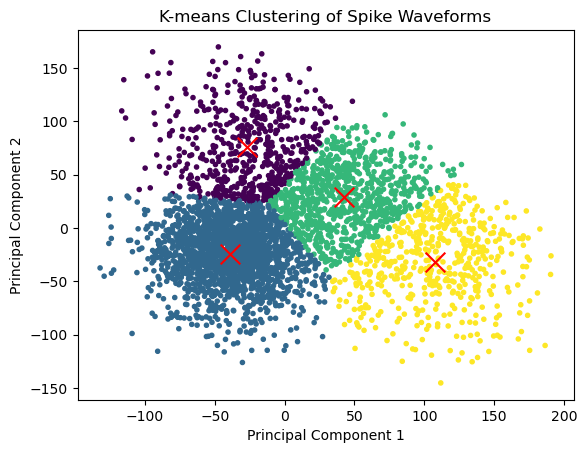

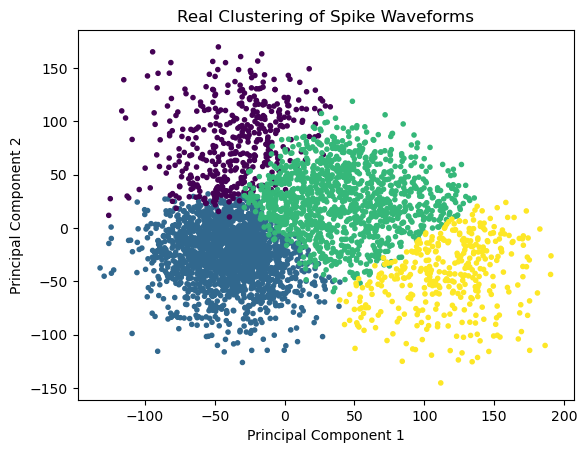

In [108]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

num=3200
# 使用K-means进行聚类
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(reduced_spike_waveforms)


labels_real=np.concatenate((np.full(wf[1,1].shape[0],1), np.full(wf[1,2].shape[0],0),np.full(wf[1,3].shape[0],2),np.full(wf[1,4].shape[0],3)), axis=0)

print(labels_real.shape,labels_real[num])
# 使用PCA进行降维以便可视化
pca = PCA(n_components=2)
reduced_spike_waveforms = pca.fit_transform(concatenated_data)


cmap = 'viridis'
vmin, vmax = min(cluster_labels.min(), labels_real.min()), max(cluster_labels.max(), labels_real.max())

# 可视化 K-means 聚类结果
plt.scatter(reduced_spike_waveforms[:, 0], reduced_spike_waveforms[:, 1], c=cluster_labels, cmap=cmap, marker='.', vmin=vmin, vmax=vmax)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200)
plt.title('K-means Clustering of Spike Waveforms')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 可视化真实类别
plt.scatter(reduced_spike_waveforms[:, 0], reduced_spike_waveforms[:, 1], c=labels_real, cmap=cmap, marker='.', vmin=vmin, vmax=vmax)
plt.title('Real Clustering of Spike Waveforms')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



In [110]:
from sklearn.metrics import r2_score
labels_real=np.concatenate((np.full(wf[1,1].shape[0],1), np.full(wf[1,2].shape[0],0),np.full(wf[1,3].shape[0],2),np.full(wf[1,4].shape[0],3)), axis=0)

silhouette_avg = silhouette_score(reduced_spike_waveforms, labels)
print("Silhouette Score:", silhouette_avg)

# for i in range(len(labels_real)):
#     print(labels_real[i],labels[i])
# print(labels_real.shape,labels.shape)
R2_kf=r2_score(labels,labels_real)
print('R2:',R2_kf) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities

Silhouette Score: 0.41494316
R2: 0.8269856836207071
